In [129]:
import os
import matplotlib.pyplot as plt
import configue
import torch
import numpy as np

In [82]:
########## Modèles issus du transfert learning à partir de la couche 4 ##########

# studied_experiment_folder = "experiments/23-03-01_18:36:08" # val : 16.35 
# studied_experiment_folder = "experiments/23-03-01_18:53:27" # val : 32.43
# studied_experiment_folder = "experiments/23-03-01_19:27:33" # val : 15.899
# studied_experiment_folder = "experiments/23-03-01_19:44:28" # val : 32.043
# studied_experiment_folder = "experiments/23-03-01_20:20:01" # val : 32.625
# studied_experiment_folder = "experiments/23-03-01_20:51:06" # val : 32.513

########## Modèles issus du fine-tuning ##########

studied_experiment_folder = "experiments/23-03-04_12:59:53"
# studied_experiment_folder = "experiments/23-03-05_00:58:03"

In [84]:
def log_to_dict(experiment_folder):
    with open(os.path.join(experiment_folder, 'log.txt'), "r") as f :
        text = f.read()
    list_lines = text.split("\n")
    result = {label.split(": ")[0]:[] for label in list_lines[0].split("\t")[:-1]}
    for line in list_lines[:-1] :
        for label in line.split("\t")[:-1] : 
            result[label.split(": ")[0]].append(float(label.split(": ")[1]))
    return result

def merge_result_dicts(list_dicts):
    result = list_dicts[0]
    for my_dict in list_dicts[1:]:
        for key in result.keys():
            result[key] += my_dict[key]
    return result
            
def get_config(experiment_folder):
    return configue.load(os.path.join(experiment_folder, "config.yaml"))

In [96]:
list_dicts = [log_to_dict(studied_experiment_folder)]
current_config = get_config(studied_experiment_folder)
while current_config["load_checkpoint"] :
    previous_path = current_config["checkpoint_path"].split("/") 
    previous_folder = os.path.join(*[previous_path[i] for i in range(previous_path.index("experiments"), len(previous_path) - 1)])
    list_dicts.insert(0, log_to_dict(previous_folder))
    current_config = get_config(previous_folder)

data = merge_result_dicts(list_dicts)

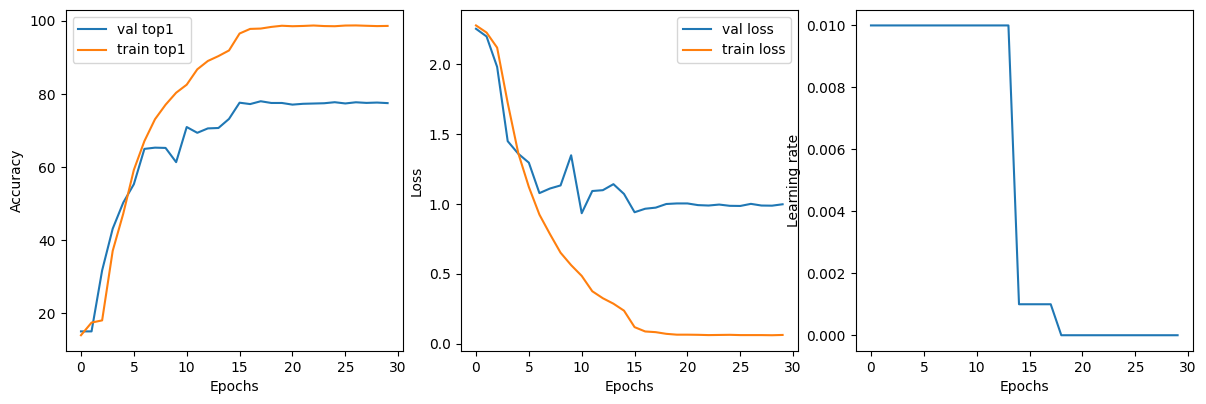

In [100]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.tight_layout()
ax1.plot(data['val_top1'], label = 'val top1')
ax1.plot(data['train_top1'], label = 'train top1')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(data['val_loss'], label = 'val loss')
ax2.plot(data['train_loss'], label = 'train loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax3.plot(data['learning_rate'], scaley='log')
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Learning rate")
plt.show()

# Analysis of the experiments of transfer learning from layer4

In [87]:
layer4_experiments = [
    "experiments/23-03-01_18:36:08",
    "experiments/23-03-01_18:53:27",
    "experiments/23-03-01_19:27:33",
    "experiments/23-03-01_19:44:28",
    "experiments/23-03-01_20:20:01",
    "experiments/23-03-01_20:51:06",
]
wd = []
lr = []
val_top = []
train_top = []
for folder in layer4_experiments : 
    local_config = get_config(folder)
    wd.append(local_config["weight_decay"])
    lr.append(local_config["learning_rate"]["initial_value"])
    val_top.append(max(log_to_dict(folder)["val_top1"]))
    train_top.append(max(log_to_dict(folder)["train_top1"]))

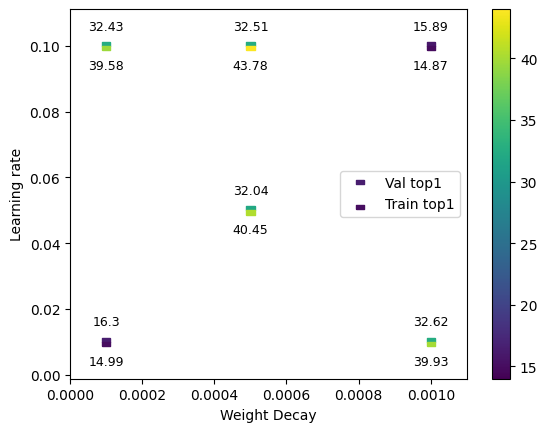

In [88]:
import matplotlib

plt.figure()
plt.scatter(wd, lr, c=val_top, marker=matplotlib.markers.MarkerStyle('s', fillstyle='top'), label="Val top1")
plt.clim(14, 44)
plt.scatter(wd, lr, c=train_top, marker=matplotlib.markers.MarkerStyle('s', fillstyle='bottom'), label="Train top1")
plt.clim(14, 44)
plt.colorbar()
xscale=max(wd) - min(wd)
yscale=max(lr) - min(lr)
for i, value in enumerate(val_top) : 
    plt.text(wd[i], lr[i]- yscale/15, str(train_top[i])[:-1], fontsize=9, ha='center', va='center')
    plt.text(wd[i], lr[i]+ yscale/15, str(val_top[i])[:-1], fontsize=9, ha='center', va='center')
plt.ylim(bottom = min(lr) - yscale/8, top= max(lr) + yscale/8)
plt.xlim(left=min(wd) - 10e-5, right=max(wd) + 10e-5)
plt.xlabel("Weight Decay")
plt.ylabel("Learning rate")
plt.legend()
plt.show()

# Analysis of the confusion matrix from fine tuning

In [138]:
confusion_matrix_folder = "experiments/23-03-04_12:59:53"
# confusion_matrix_folder = "experiments/23-03-05_00:58:03"
with open(os.path.join(confusion_matrix_folder, "confusion_matrix_weighted.txt")) as f : 
    text = f.read()
matrix = eval("torch." + text)

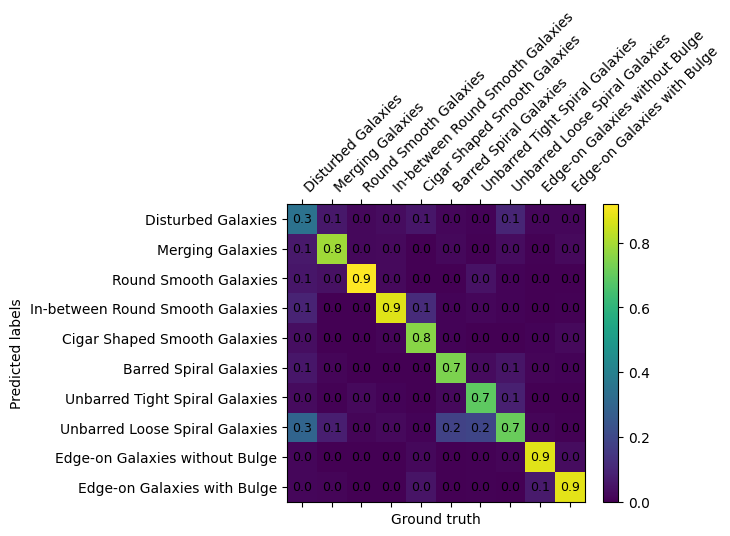

In [139]:
labels_name = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies", "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]
plt.matshow(matrix)
plt.xticks(ticks = [i for i in range(10)], labels=labels_name, rotation=45, ha='left')
plt.yticks(ticks = [i for i in range(10)], labels=labels_name)
plt.colorbar(shrink=0.8)
plt.xlabel("Ground truth")
plt.ylabel("Predicted labels")
for (i, j), z in np.ndenumerate(matrix):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=9)
plt.show()